# Malaria Detection

This notebook is designed to create a model that predicts whether a cell is infected with malaria or not. The dataset used is the [Malaria Cell Images Dataset](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria) from Kaggle. The dataset contains 27,558 cell images with equal instances of parasitized and uninfected cells. The images are of different sizes.

> Import libraries and set up source directories


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from random import randint
from skimage.transform import resize
from skimage import io, img_as_float, color
import seaborn as sns
import concurrent.futures
import pickle
import cv2
import gc

root = "../data"
labels = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
datapath = []
for label in labels:
    datapath.append(os.path.join(root, label))
datapath


['../data/Uninfected', '../data/Parasitized']

## Introduction

We have 2 classes of images: Uninfected and Parasitized. We will use the following encoding for them:

- 0 for Uninfected
- 1 for Parasitized

> Utility Section


In [2]:
def load_image(path):
    """Wrapper function for skimage.io.imread parallelization
    The image is returned as a numpy array with shape (M, N, 3) and dtype uint8."""
    return io.imread(path, pilmode="RGB")


def load_image_bw(path):
    """Wrapper function for skimage.io.imread parallelization
    The image is returned as a numpy array with shape (M, N) and dtype uint8."""
    return io.imread(path, pilmode="L")

In [3]:
"""Load the images in parallel using concurrent.futures and store them in different lists both in color and in black and white."""
# We use concurrent.futures to speed up the process, since it is a CPU-bound task
uninf_path = [os.path.join(datapath[0], _) for _ in os.listdir(datapath[0])]
para_path = [os.path.join(datapath[1], _) for _ in os.listdir(datapath[1])]
with concurrent.futures.ProcessPoolExecutor() as executor:
    uninf_imgs = executor.map(load_image, uninf_path)
    para_imgs = executor.map(load_image, para_path)
# convert the map object to a list
uninf_imgs = list(uninf_imgs)
para_imgs = list(para_imgs)
with concurrent.futures.ProcessPoolExecutor() as executor:
    uninf_imgs_bw = executor.map(load_image_bw, uninf_path)
    para_imgs_bw = executor.map(load_image_bw, para_path)
uninf_imgs_bw = list(uninf_imgs_bw)
para_imgs_bw = list(para_imgs_bw)

> Display sample images

We want to see some images to get a feel for the data and to make sure that the data is loaded correctly. We also want to see if there is something detectable by simply looking at the images before we start training a model.

_Using images as dataset means that we have one variable per pixel, and each image is a point in a very high-dimensional space. Single variable distributions and pairwise correlations are completely meaningless and unmanageable._


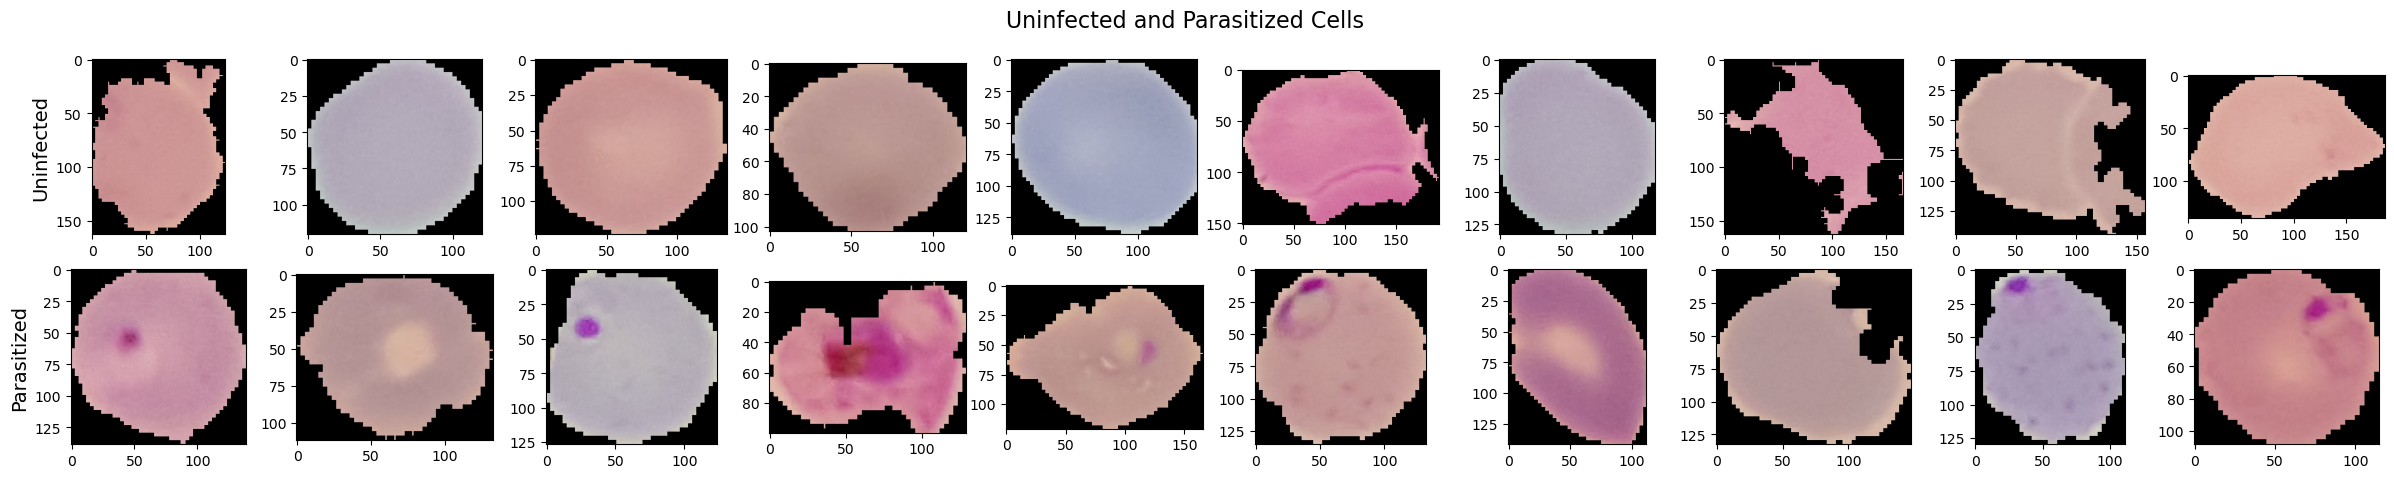

In [4]:
# select 10 random integers - we will use them to select images along this initial process
uninf_index = [randint(0, len(os.listdir(datapath[0]))) for _ in range(10)]
para_index = [randint(0, len(os.listdir(datapath[1]))) for _ in range(10)]
# plot the images
fig, ax = plt.subplots(2, 10, figsize=(30, 5))
fig.suptitle("Uninfected and Parasitized Cells", fontsize=16)
for i in range(10):
    ax[0, i].imshow(uninf_imgs[uninf_index[i]])
    ax[1, i].imshow(para_imgs[para_index[i]])
ax[0, 0].set_ylabel("Uninfected", fontsize=14)
ax[1, 0].set_ylabel("Parasitized", fontsize=14)
plt.show()


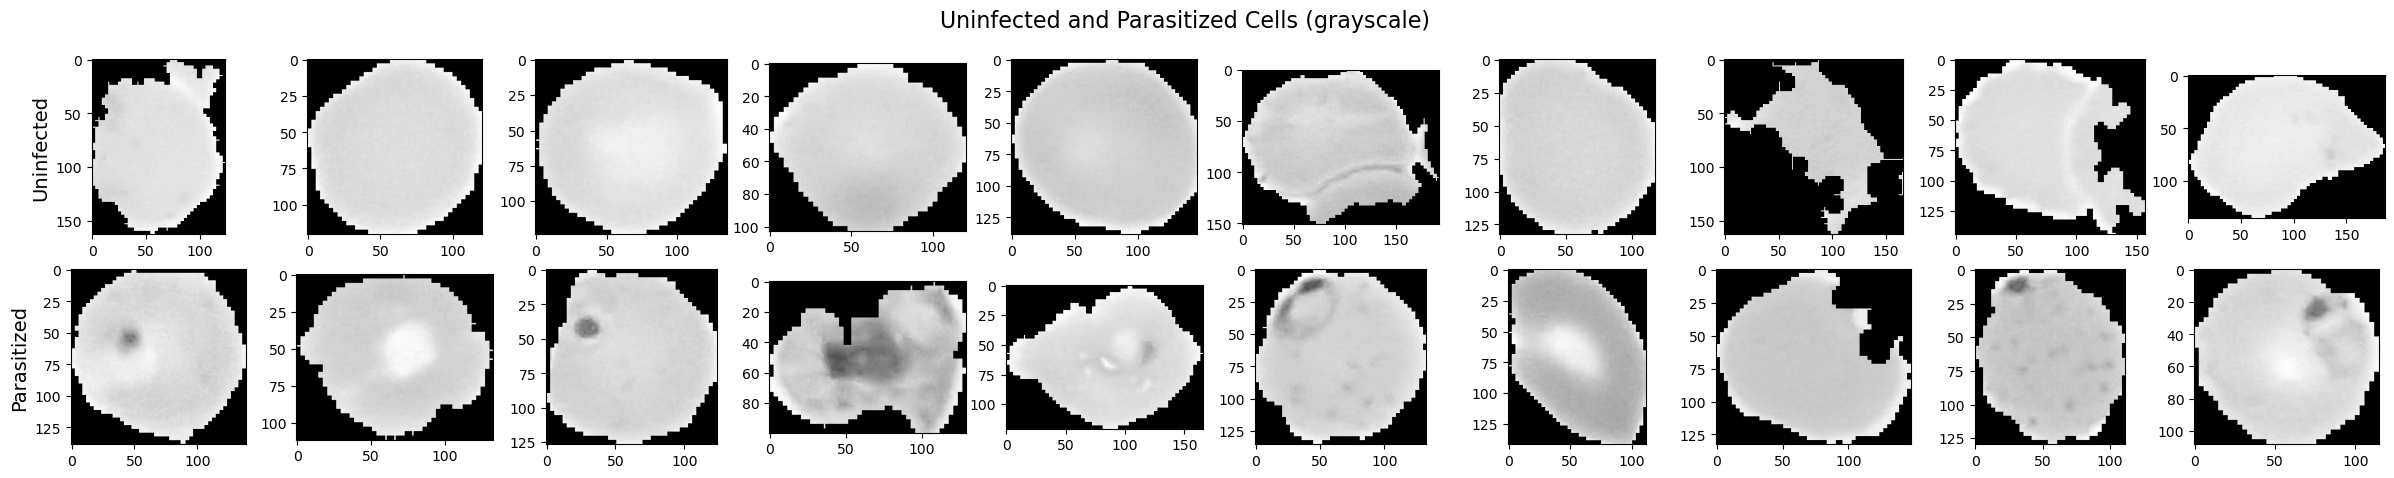

In [5]:
# plot the same images but in grayscale
fig, ax = plt.subplots(2, 10, figsize=(30, 5))
fig.suptitle("Uninfected and Parasitized Cells (grayscale)", fontsize=16)
for i in range(10):
    ax[0, i].imshow(uninf_imgs_bw[uninf_index[i]], cmap="gray")
    ax[1, i].imshow(para_imgs_bw[para_index[i]], cmap="gray")
ax[0, 0].set_ylabel("Uninfected", fontsize=14)
ax[1, 0].set_ylabel("Parasitized", fontsize=14)
plt.show()


## Dataset summary

Inspecting the images we can see that:

- Cells are of different shapes and sizes and that the infected cells have some visible violet spots.
- The morphology of the cells is not uniform and the violet spots are not always in the same place.
- The black borders presents in some images are not relevant and should be removed to avoid noise.
- Due to the fact that the color of the cells is not uniform, the violet spots could be more or less visible depending on the background color of the cell. Maybe the grayscale images will be more useful for the model.
- From the grayscale images we can see that the violet spots are darker than the rest of the cell and that the uninfected cells are lighter. This could be useful for the model, maybe with some preprocessing we can make the darker spots more visible.

We will use the grayscale images in the following steps, but we will keep the RGB images for future use.

> Create data structures that will hold the images and their labels

We are going to preprocess the images in order to make them more suitable for the model. Using the grayscale images we will:

1. Remove black borders.
2. Resize the images to standardize the size.
3. (next) Standardize the images using sklearn.preprocessing scalers. We will cross-validate the best scaler for our model.

**Note:** This process is also useful to reduce computation time when training the model.


In [6]:
"""
    Preprocessing functions to transform an image to be used in the model.
    We will use other functions later like sklearn scalers.
"""

def remove_background(image):
    """Remove the black background of the image. The function takes the image and the threshold value. If the pixel is below the threshold, it is set to 0.
    Args:
        image (np.ndarray): image to be processed loaded with skimage.io.imread
    """
    img = image.copy()
    img[image == 0.0] = np.max(img)
    return img


def make_dataset(image, size=48):
    """Preprocessing function to transform an image to be used in the model. The steps are:
       1. Remove the black background
       2. Resize the image to the desired size
    We remove the black background before resizing the image to avoid having black borders in the resized image due to the interpolation maked by the resize function.
    The image is then flattened to be used in the model.
    Args:
        image (np.ndarray): image to be processed loaded with skimage.io.imread
        size (int): desired size of the image, the image will be resized to (size, size)
    """
    img = remove_background(image)
    img = resize(img, (size, size), anti_aliasing=True)
    return np.asarray(img).flatten()


In [7]:
# make a first preprocessing step to remove the black background and resize the images so that they have the same size and can be used as input for the model
with concurrent.futures.ProcessPoolExecutor() as executor:
    u = np.asarray(list(executor.map(make_dataset, uninf_imgs_bw)))
    p = np.asarray(list(executor.map(make_dataset, para_imgs_bw)))
del (
    datapath,
    label,
    labels,
    uninf_path,
    para_path,
    uninf_imgs,
    para_imgs,
    uninf_imgs_bw,
    para_imgs_bw,
    ax,
    fig,
    i,
    executor,
)
gc.collect()
# create matrix of features from the numpy vectors
X = np.concatenate((u, p))
# create matrix of labels from the numpy vectors length
y = np.concatenate((np.zeros(len(u)), np.ones(len(p)))).reshape(-1, 1)
# pandas dataframe
df = pd.DataFrame(data=X, columns=range(np.shape(X)[1])).merge(
    pd.DataFrame(data=y, columns=["labels"]), left_index=True, right_index=True
)
df.head()


,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,labels
0,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,...,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.815686,0.0
1,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,...,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.745098,0.0
2,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,...,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.741176,0.0
3,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,...,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.768627,0.0
4,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,...,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.725490,0.0


In [8]:
# store the dataframe in a csv file
# df.to_csv(os.path.join(root,"data.csv"), index=False)

Simple check on the distribution of the labels in the training and test sets. This will lead to see that our dataset is balanced.


Is the dataset balanced?  Yes


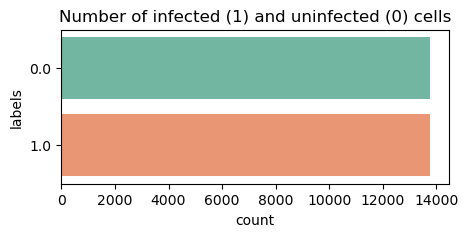

In [9]:
# Count the number of uninfected and infected cells
plt.figure(figsize=(5, 2), dpi=100)
plt.title("Number of infected (1) and uninfected (0) cells")
sns.countplot(y=df["labels"], palette="Set2")
print(
    "Is the dataset balanced? ",
    "Yes" if df["labels"].value_counts()[0] == df["labels"].value_counts()[1] else "No",
)

> Split the dataset into Training and Test sets

- Training set: 70% of the dataset -> we will use this set to train the model after data augmentation
- Test set: 30% of the dataset -> we will use this set to test the model

_During the training phase we will use K-Fold Cross Validation to evaluate the model and tune its hyperparameters._


In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training validation and test sets
test_ratio = 0.3
# now make two splits:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df.drop(columns=["labels"]),
    df["labels"],
    test_size=test_ratio,
    shuffle=True,
    stratify=y,
)

## Understanding model complexity

Using images, our dataset has a lot of features, so we will try to understand if model reduction techniques can help us. We will use PCA to reduce the dimensionality because we have only 2 classes and a supervised model is not necessary.

If the explained variance is not enough to explain the data, we need to use a more complex model. Probably a neural network.

_About LDA: we don't use LDA as a dimensionality reduction method because with just 2 classes the output of the reduction will have only 1 dimension._

> PCA


Explained variance ratio: 0.90


0

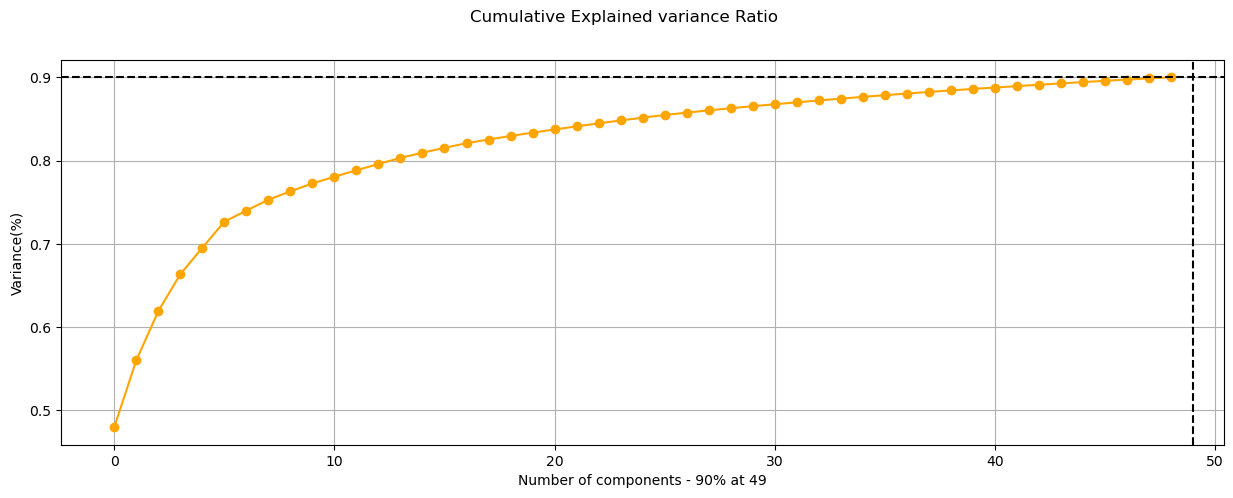

In [11]:
# Calculate the explained variance ratio to determine the number of components needed to explain 95% of the variance
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)
pca.fit(X_train_val)
fig = plt.figure(figsize=(15, 5))
plt.suptitle("Cumulative Explained variance Ratio")
plt.xlabel(f"Number of components - 90% at {pca.components_.shape[0]}")
plt.ylabel("Variance(%)")
plt.plot(
    range(len(pca.explained_variance_ratio_)),
    pca.explained_variance_ratio_.cumsum(),
    "o-",
    color="orange",
)
plt.axhline(y=0.9, color="black", linestyle="--")
plt.axvline(x=pca.components_.shape[0], color="black", linestyle="--")
plt.grid()
print(f"Explained variance ratio: {pca.explained_variance_ratio_.cumsum()[-1]:.2f}")
del pca, fig
gc.collect()

**Analysis:** Using 111 components we can explain 95% of the variance, so we can use this number as a threshold to reduce the dimensionality of the dataset from 2304 to 111.

> Scaling the dataset

We will scale the dataset with two different techniques that produced better results during the analysis: StandardScaler and RobustScaler. The former will scale the data to have zero mean and unit variance, while the latter will set the mean to zero (and unit variance if enabled) according to the interquartile (25-75%) range.

_Note: the std scaler is designed to reduce the effect of outliers in the data. If our model will perform better with the std that means that outliers are present in the data._


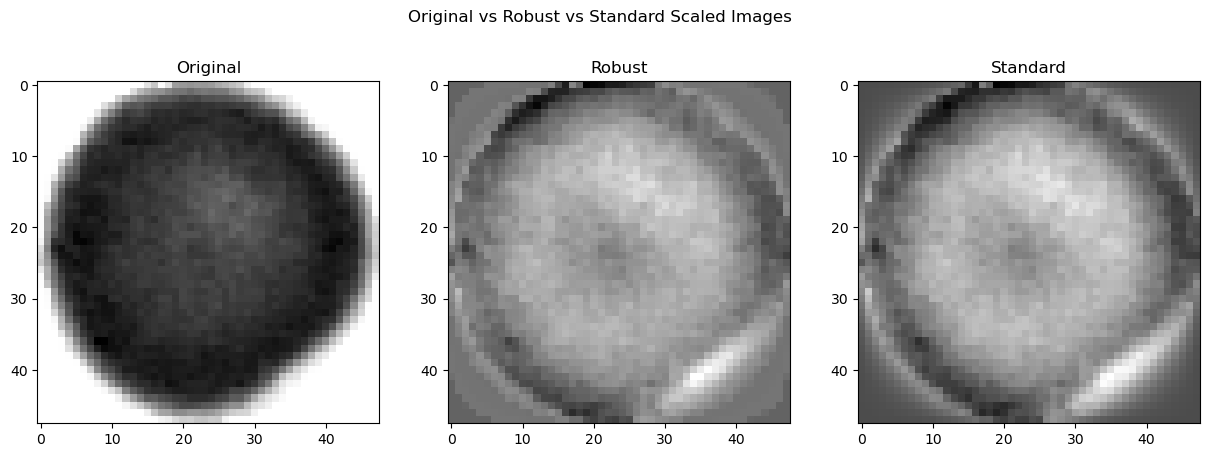

In [12]:
# Prepare the data for the model
from sklearn.preprocessing import StandardScaler, RobustScaler
# initialize the scalers
robust_scale = RobustScaler().fit(X_train_val)
std_scale = StandardScaler().fit(X_train_val)
# fit and transform the data
x_robust = robust_scale.transform(X_train_val)
x_std = std_scale.transform(X_train_val)
# plot samples of the original, robust and standard scaled images
plt.figure(figsize=(15, 5), dpi=100)
plt.suptitle("Original vs Robust vs Standard Scaled Images")
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(X_train_val.iloc[1500].values.reshape(48,48), cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Robust")
plt.imshow(x_robust[1500].reshape(48,48), cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Standard")
plt.imshow(x_std[1500].reshape(48,48), cmap='gray')

# Classification tests

We will use simple models to test the dataset and to understand if we can get a good accuracy with a simple model. Then we will try to optimize the best scoring model searching for the best hyperparameters.

_Note: we will show Confusion Matrix, Precision-Recall, and ROC Curve for better combination of each model._


In [101]:
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, precision_recall_curve, roc_curve, classification_report, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score

def get_scores(model, X_train, y_train, X_test, y_test, display=False, name=None):
    """
    Function to calculate the accuracy, precision, recall and f1 score of a model.
    The confusion matrix is calculated and plotted if display is set to True. In this case, we can also see the accuracy of the model
    because we are in a binary classification problem. The order of values in the confusion matrix is: [TN, FP, FN, TP]
    Plot for the precision-recall curve and the ROC curve are also plotted if display is set to True. 
        - High precision values indicate that the model is not labeling many samples as positive that are actually negative. 
        - High recall values indicate that the model is labeling many samples as positive that are actually positive.
        - Higher is the area under the ROC curve, better is the separation between the two classes.
    Args:
        model (sklearn model): model to be evaluated. Must implement predict and score methods.
        X (np.ndarray): training data
        y (np.ndarray): training labels
        X_test (np.ndarray): test data
        y_test (np.ndarray): test labels
    """
    if display: 
        assert name is not None, "You must provide a name for the plot"
    fitted = model.fit(X_train, y_train)
    y_pred = fitted.predict(X_test)
    y_proba = fitted.predict_proba(X_test) if hasattr(fitted, "predict_proba") else fitted._final_estimator._predict_proba_lr(X_test)
    y_score = fitted.decision_function(X_test) if hasattr(fitted, "decision_function") else y_proba[:,1]
    cm = confusion_matrix(y_test, y_pred, labels=fitted.classes_, normalize='true')
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])     
    auc = roc_auc_score(y_test, y_proba[:,1])
    if display:
        fig, ax = plt.subplots(1,3, figsize=(20,5))
        fig.suptitle(f"Model: {name} - Accuracy: {acc.mean():.2f} - F1: {f1.mean():.2f} - Recall: {recall.mean():.2f} - Precision: {precision.mean():.2f} - TPR: {tpr.mean():.2f} - FPR: {fpr.mean():.2f}")
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=fitted.classes_).plot(ax = ax[0], colorbar=False)
        cm_display.ax_.set_title('Confusion Matrix (Normalized)')
        cm_display.ax_.set_ylabel('True label')
        cm_display.ax_.set_xlabel('Predicted label')           
        pre_rec_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax = ax[1])
        pre_rec_display.ax_.set_title('Precision-Recall Curve')
        pre_rec_display.ax_.set_ylabel('Precision')
        pre_rec_display.ax_.set_xlabel('Recall')
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax = ax[2])        
        roc_display.ax_.set_title('ROC Curve - AUC: {:.3f}'.format(auc))
        roc_display.ax_.set_ylabel(f'True Positive Rate')
        roc_display.ax_.set_xlabel(f'False Positive Rate')
    scores = classification_report(y_test, y_pred, labels=fitted.classes_, output_dict=True)
    keys = list(scores[str(float('0'))])+['AUC']
    index = list(scores.keys())+['ROC']
    df = pd.DataFrame(index = index, columns = keys)
    for k in list(index):
        if k == str(float('0')) or k == str(float('1')):
            df.loc[k] = list(scores[k].values())+[np.NaN]
        elif k == 'accuracy':
            df.loc[k] = [np.NaN, np.NaN, scores[k], X_test.shape[0]]+[np.NaN]
        elif k=='macro avg' or k=='weighted avg':
            df.loc[k] = list(scores[k].values())+[np.NaN]
        else:
            df.loc[k] = [np.NaN, np.NaN, np.NaN, np.NaN, auc]
    return df, cm

    

In [139]:
"""Pipelines"""
# We will use pipelines to make the testing workflow easier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
# define the models - parameters are selected looking at the documentation and the results of some tests (no optimization was done at the moment)
sgdc = SGDClassifier(loss='modified_huber', penalty='elasticnet', max_iter=10000, n_jobs=-1)
lsvc = LinearSVC(C=1e-4, dual=False, max_iter=10000)
lr = LogisticRegression(C=1e-4, n_jobs=-1, solver='saga', max_iter=10000, dual=False)
knc = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
rfc = RandomForestClassifier(
        n_jobs=-1, n_estimators=500, max_depth=40, min_samples_split=3, min_samples_leaf=6,
        criterion='entropy', bootstrap=True
    )
ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.1, estimator=DecisionTreeClassifier(max_depth=5, min_samples_leaf=6, max_features='log2', ccp_alpha=0.001))   
hgb = HistGradientBoostingClassifier(learning_rate=0.05, max_iter=300, early_stopping=True)
# define robust pipelines
robust_pipe_SGDC = make_pipeline(RobustScaler(), Nystroem(n_components=1000, n_jobs=-1), sgdc)
robust_pipe_LSVC = make_pipeline(RobustScaler(), lsvc)
robust_pipe_LR = make_pipeline(RobustScaler(), lr)
robust_pipe_KNN = make_pipeline(RobustScaler(), knc)
robust_pipe_RF = make_pipeline(RobustScaler(), rfc)
robust_pipe_ADA = make_pipeline(RobustScaler(), ada)
robust_pipe_HGB = make_pipeline(RobustScaler(), hgb)
# define std pipelines
std_pipe_SGDC = make_pipeline(StandardScaler(), Nystroem(n_components=1000, n_jobs=-1), sgdc)
std_pipe_LSVC = make_pipeline(StandardScaler(), lsvc)
std_pipe_LR = make_pipeline(StandardScaler(), lr)
std_pipe_KNN = make_pipeline(StandardScaler(), knc)
std_pipe_RF = make_pipeline(StandardScaler(), rfc)
std_pipe_ADA = make_pipeline(StandardScaler(), ada)
std_pipe_HGB = make_pipeline(StandardScaler(), hgb)
# define robust pipelines with PCA
r_pca_pipe_SGDC = make_pipeline(RobustScaler(), PCA(n_components=0.9), Nystroem(n_components=1000, n_jobs=-1), sgdc)
r_pca_pipe_LSVC = make_pipeline(RobustScaler(), PCA(n_components=0.9), lsvc)
r_pca_pipe_LR = make_pipeline(RobustScaler(), PCA(n_components=0.9), lr)
r_pca_pipe_KNN = make_pipeline(RobustScaler(), PCA(n_components=0.9), knc)
r_pca_pipe_RF = make_pipeline(RobustScaler(), PCA(n_components=0.9), rfc)
r_pca_pipe_ADA = make_pipeline(RobustScaler(), PCA(n_components=0.9), ada)
r_pca_pipe_HGB = make_pipeline(RobustScaler(), PCA(n_components=0.9), hgb)
# define std pipelines with PCA
s_pca_pipe_SGDC = make_pipeline(StandardScaler(), PCA(n_components=0.9), Nystroem(n_components=1000, n_jobs=-1), sgdc)
s_pca_pipe_LSVC = make_pipeline(StandardScaler(), lsvc)
s_pca_pipe_LR = make_pipeline(StandardScaler(), PCA(n_components=0.9), lr)
s_pca_pipe_KNN = make_pipeline(StandardScaler(), PCA(n_components=0.9), knc)
s_pca_pipe_RF = make_pipeline(StandardScaler(), PCA(n_components=0.9), rfc)
s_pca_pipe_ADA = make_pipeline(StandardScaler(), PCA(n_components=0.9), ada)
s_pca_pipe_HGB = make_pipeline(StandardScaler(), PCA(n_components=0.9), hgb)

> Stochastic Gradient Descent

Classifier that implements the Stoachastic Gradient Descent algorithm. [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

,precision,recall,f1-score,support,AUC
0.0,0.852008,0.877358,0.864498,4134,NaN
1.0,0.873598,0.847605,0.860405,4134,NaN
accuracy,NaN,NaN,0.862482,8268,NaN
macro avg,0.862803,0.862482,0.862451,8268,NaN
weighted avg,0.862803,0.862482,0.862451,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.924512


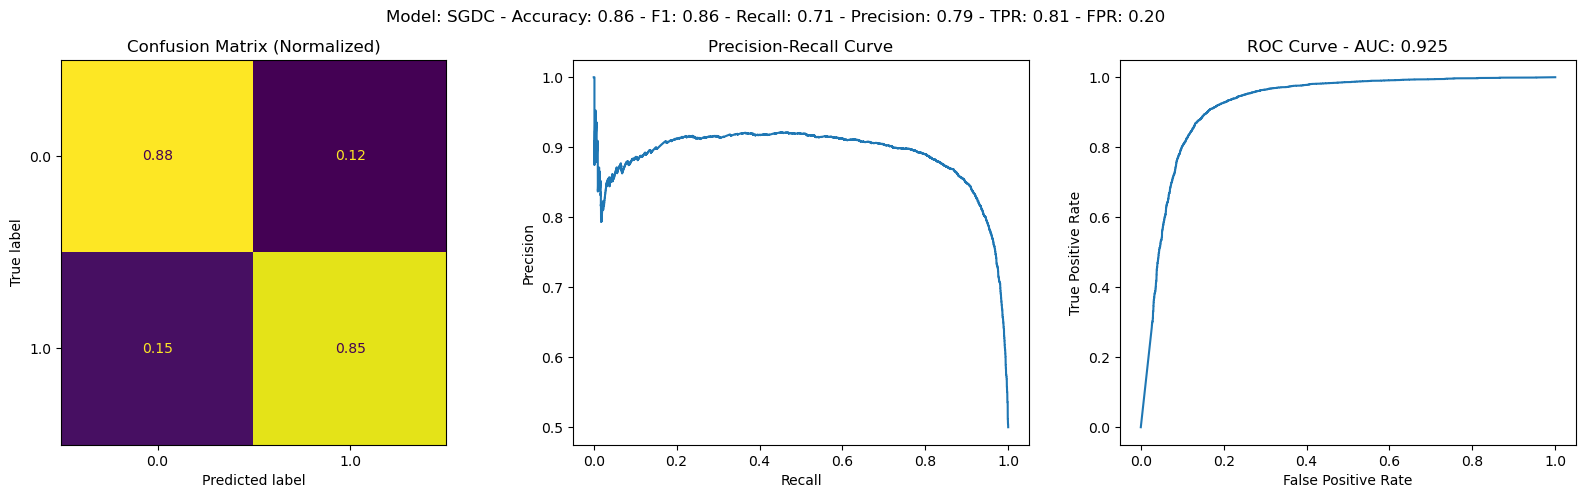

In [77]:
r_score_sgd, r_cm_sgd = get_scores(robust_pipe_SGDC, X_train_val, y_train_val, X_test, y_test, display=True, name='SGDC')
r_score_sgd

In [106]:
#rp_score_sgd, rp_cm_sgd = get_scores(r_pca_pipe_SGDC, X_train_val, y_train_val, X_test, y_test)
#rp_score_sgd

,precision,recall,f1-score,support,AUC
0.0,0.906707,0.3597,0.515068,4134,NaN
1.0,0.600634,0.96299,0.739825,4134,NaN
accuracy,NaN,NaN,0.661345,8268,NaN
macro avg,0.75367,0.661345,0.627446,8268,NaN
weighted avg,0.75367,0.661345,0.627446,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.762707


In [79]:
#s_score_sgd, s_cm_sgd = get_scores(std_pipe_SGDC, X_train_val, y_train_val, X_test, y_test)
#_score_sgd

In [107]:
#sp_score_sgd, sp_cm_sgd = get_scores(s_pca_pipe_SGDC, X_train_val, y_train_val, X_test, y_test)
#sp_score_sgd

,precision,recall,f1-score,support,AUC
0.0,0.948542,0.267537,0.417358,4134,NaN
1.0,0.573641,0.985486,0.725169,4134,NaN
accuracy,NaN,NaN,0.626512,8268,NaN
macro avg,0.761092,0.626512,0.571264,8268,NaN
weighted avg,0.761092,0.626512,0.571264,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.762138


> Linear Support Vector Classification

Supervised learning model for classification. It's an optimized implementation of the Support Vector Machine algorithm for the case of a linear kernel. It is useful in high dimensional spaces like images.

In [81]:
#r_score_lsvc, r_cm_lsvc = get_scores(robust_pipe_LSVC, X_train_val, y_train_val, X_test, y_test)
#r_score_lsvc

In [82]:
#rp_score_lsvc, rp_cm_lsvc = get_scores(r_pca_pipe_LSVC, X_train_val, y_train_val, X_test, y_test)
#rp_score_lsvc

,precision,recall,f1-score,support,AUC
0.0,0.669953,0.756168,0.710455,4134,NaN
1.0,0.720155,0.627479,0.670631,4134,NaN
accuracy,NaN,NaN,0.691824,8268,NaN
macro avg,0.695054,0.691824,0.690543,8268,NaN
weighted avg,0.695054,0.691824,0.690543,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.738586


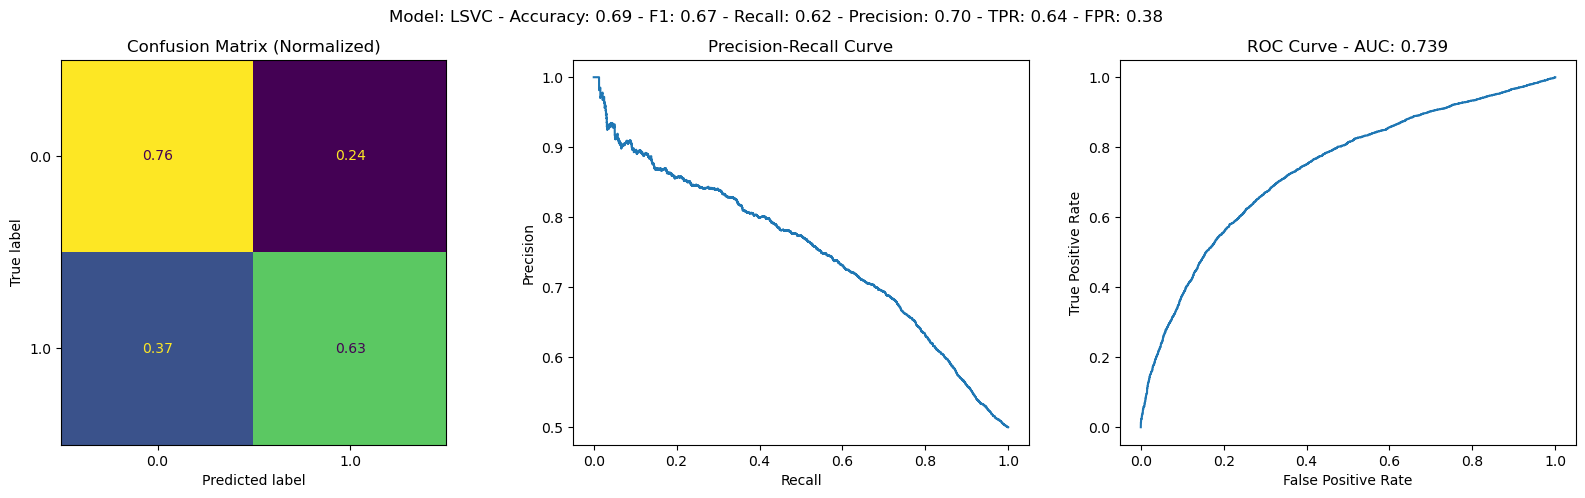

In [95]:
s_score_lsvc, s_cm_lsvc = get_scores(std_pipe_LSVC, X_train_val, y_train_val, X_test, y_test, display=True, name='LSVC')
s_score_lsvc

In [ ]:
#sp_score_lsvc, sp_cm_lsvc = get_scores(s_pca_pipe_LSVC, X_train_val, y_train_val, X_test, y_test)
#sp_score_lsvc    

> Logistic Regression

Supervised learning algorithm. It is used to predict a binary outcome (1 / 0, Yes / No, True / False) given a set of independent variables. It is a special case of linear regression where the dependent variable is categorical in nature. It is used to estimate the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick.

In [ ]:
#r_score_lr, r_cm_lr = get_scores(robust_pipe_LR, X_train_val, y_train_val, X_test, y_test)
#r_score_lr

In [ ]:
#rp_score_lr, rp_cm_lr = get_scores(r_pca_pipe_LR, X_train_val, y_train_val, X_test, y_test)
#rp_score_lr

,precision,recall,f1-score,support,AUC
0.0,0.675028,0.735607,0.704017,4134,NaN
1.0,0.70954,0.645864,0.676206,4134,NaN
accuracy,NaN,NaN,0.690735,8268,NaN
macro avg,0.692284,0.690735,0.690111,8268,NaN
weighted avg,0.692284,0.690735,0.690111,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.744021


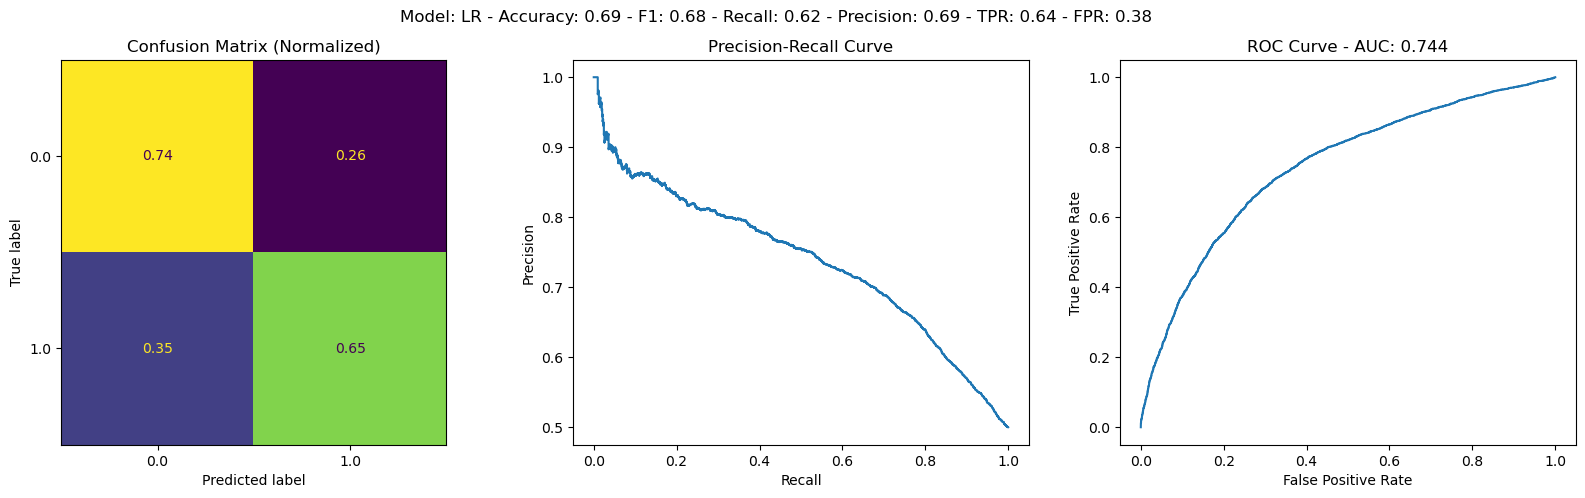

In [96]:
s_score_lr, s_cm_lr = get_scores(std_pipe_LR, X_train_val, y_train_val, X_test, y_test, display=True, name='LR')
s_score_lr

In [ ]:
#sp_score_lr, sp_cm_lr = get_scores(s_pca_pipe_LR, X_train_val, y_train_val, X_test, y_test)
#sp_score_lr

> K-Nearest Neighbors

Supervised learning algorithm based on the k-nearest neighbors principle. it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

In [ ]:
#r_score_knn, r_cm_knn = get_scores(robust_pipe_KNN, X_train_val, y_train_val, X_test, y_test)
#r_score_knn

,precision,recall,f1-score,support,AUC
0.0,0.596136,0.947992,0.731976,4134,NaN
1.0,0.873081,0.357765,0.50755,4134,NaN
accuracy,NaN,NaN,0.652879,8268,NaN
macro avg,0.734609,0.652879,0.619763,8268,NaN
weighted avg,0.734609,0.652879,0.619763,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.751086


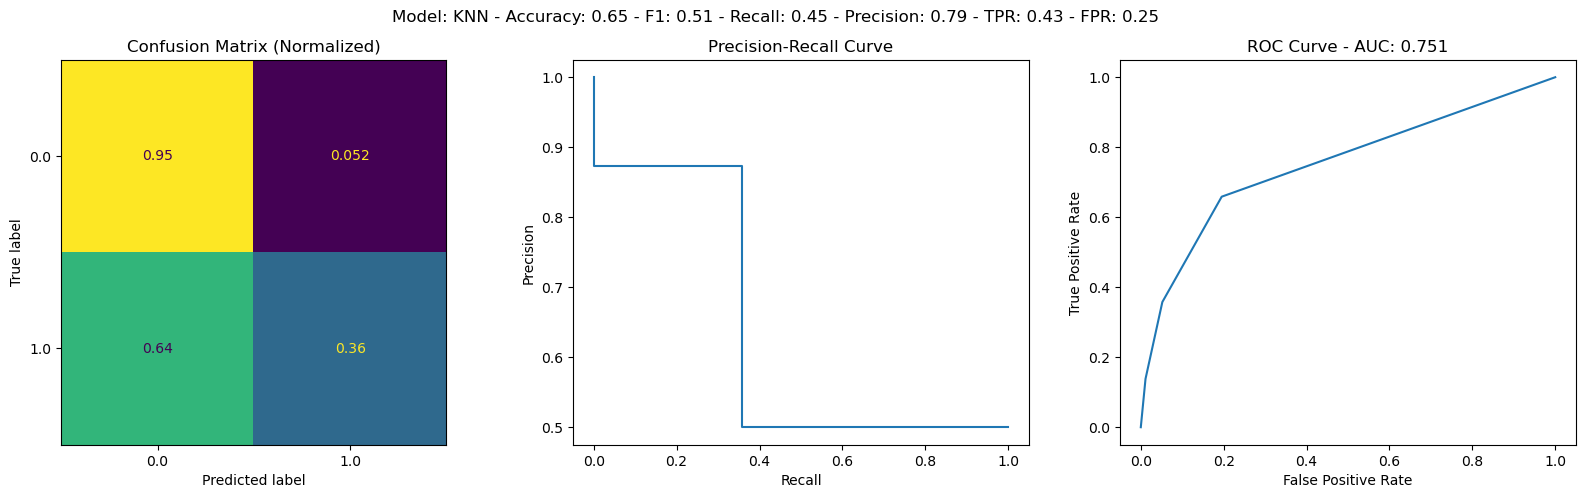

In [102]:
rp_score_knn, rp_cm_knn = get_scores(r_pca_pipe_KNN, X_train_val, y_train_val, X_test, y_test, display=True, name='KNN')
rp_score_knn

In [ ]:
#s_score_knn, s_cm_knn = get_scores(std_pipe_KNN, X_train_val, y_train_val, X_test, y_test)
#s_score_knn

In [ ]:
#sp_score_knn, sp_cm_knn = get_scores(s_pca_pipe_KNN, X_train_val, y_train_val, X_test, y_test)
#sp_score_knn

> Random Forest

Tree-based model that uses a number of decision trees to predict the outcome of a data point with the purpose of reducing the error rate of the model trading off variance for bias to reduce the overfitting.

In [ ]:
#r_score_rf, r_cm_rf = get_scores(robust_pipe_RF, X_train_val, y_train_val, X_test, y_test)
#r_score_rf

In [ ]:
#rp_score_rf, rp_cm_rf = get_scores(r_pca_pipe_RF, X_train_val, y_train_val, X_test, y_test)
#rp_score_rf

In [ ]:
#s_score_rf, s_cm_rf = get_scores(std_pipe_RF, X_train_val, y_train_val, X_test, y_test)
#s_score_rf

,precision,recall,f1-score,support,AUC
0.0,0.920706,0.794872,0.853174,4134,NaN
1.0,0.819536,0.931543,0.871957,4134,NaN
accuracy,NaN,NaN,0.863208,8268,NaN
macro avg,0.870121,0.863208,0.862566,8268,NaN
weighted avg,0.870121,0.863208,0.862566,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.938908


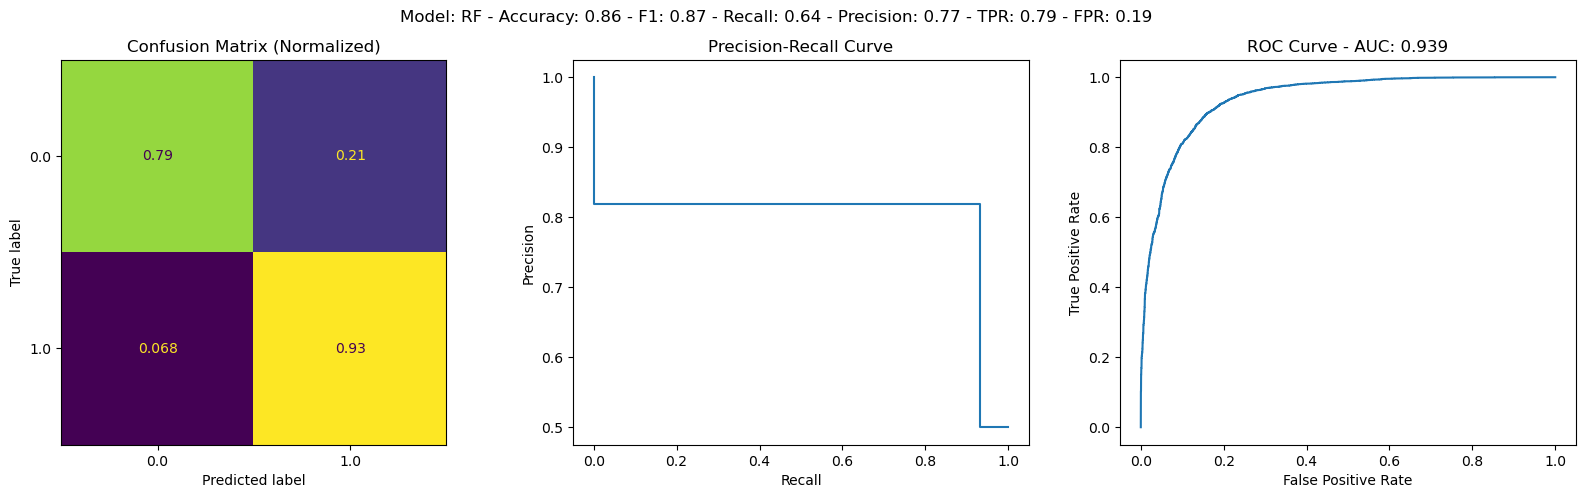

In [103]:
sp_score_rf, sp_cm_rf = get_scores(s_pca_pipe_RF, X_train_val, y_train_val, X_test, y_test, display=True, name='RF')
sp_score_rf

> AdaBoost

Model that fit a sequence of weak learners (models that are slightly better than random guessing) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction.

In [ ]:
#r_score_ada, r_cm_ada= get_scores(robust_pipe_ADA, X_train_val, y_train_val, X_test, y_test)
#r_score_ada

,precision,recall,f1-score,support,AUC
0.0,0.885092,0.845912,0.865059,4134,NaN
1.0,0.852444,0.890179,0.870903,4134,NaN
accuracy,NaN,NaN,0.868045,8268,NaN
macro avg,0.868768,0.868045,0.867981,8268,NaN
weighted avg,0.868768,0.868045,0.867981,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.938264


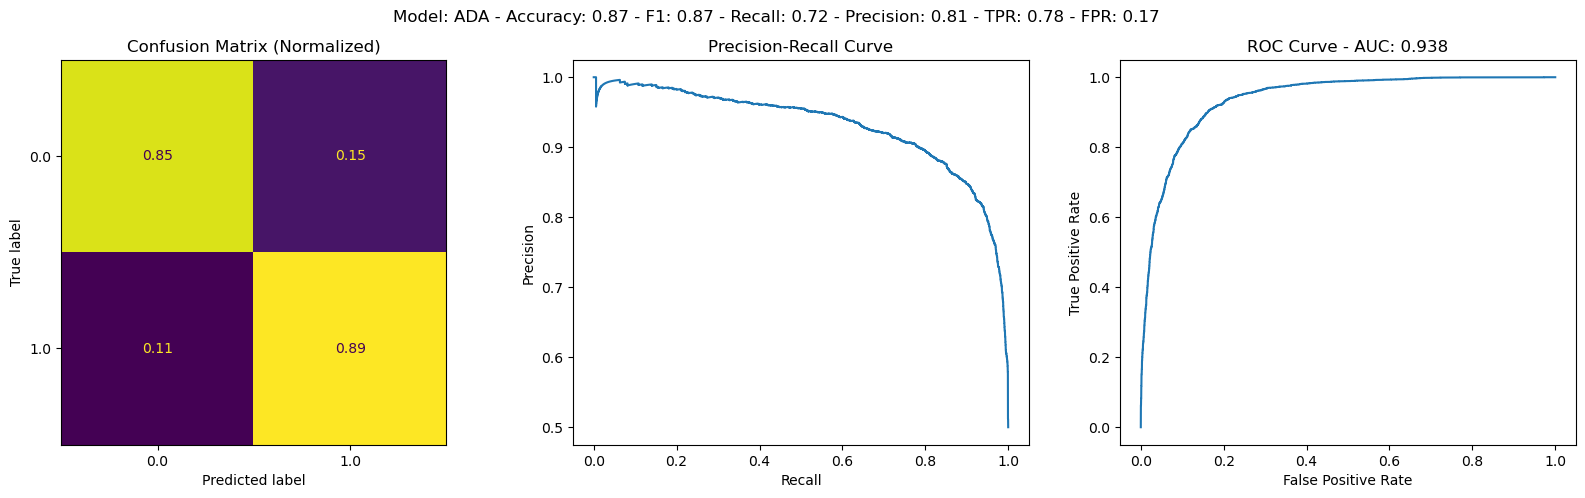

In [104]:
rp_score_ada, rp_cm_ada= get_scores(r_pca_pipe_ADA, X_train_val, y_train_val, X_test, y_test, display=True, name='ADA')
rp_score_ada

In [ ]:
#s_score_ada, s_cm_ada= get_scores(std_pipe_ADA, X_train_val, y_train_val, X_test, y_test)
#s_score_ada

In [ ]:
#sp_score_ada, sp_cm_ada= get_scores(s_pca_pipe_ADA, X_train_val, y_train_val, X_test, y_test)
#sp_score_ada

> Hist Gradient (tree) Boosting

Optimized implementation of gradient boosting decision trees. This estimators first bin the input samples into integer-valued bins, reducing the number of splits to build the trees. The speed-up cames from the fact that the algorithm uses integer-based data structures to represent the binned data, which is faster than using the original floating-point values.

,precision,recall,f1-score,support,AUC
0.0,0.894521,0.94775,0.920366,4134,NaN
1.0,0.944444,0.888244,0.915482,4134,NaN
accuracy,NaN,NaN,0.917997,8268,NaN
macro avg,0.919482,0.917997,0.917924,8268,NaN
weighted avg,0.919482,0.917997,0.917924,8268,NaN
ROC,NaN,NaN,NaN,NaN,0.969582


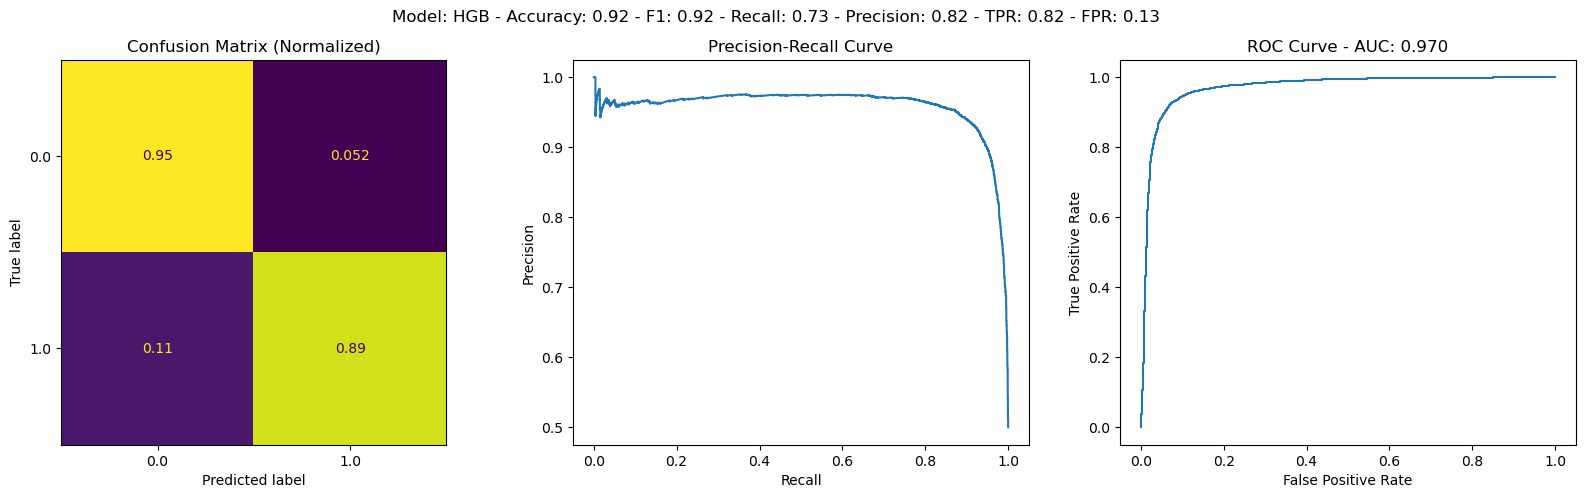

In [140]:
r_score_hgb, r_cm_hgb = get_scores(robust_pipe_HGB, X_train_val, y_train_val, X_test, y_test, display=True, name='HGB')
r_score_hgb

In [ ]:
#rp_score_hgb, rp_cm_hgb = get_scores(r_pca_pipe_HGB, X_train_val, y_train_val, X_test, y_test)
#rp_score_hgb

In [ ]:
#s_score_hgb, s_cm_hgb = get_scores(std_pipe_HGB, X_train_val, y_train_val, X_test, y_test)
#s_score_hgb

In [ ]:
#sp_score_hgb, sp_cm_hgb = get_scores(s_pca_pipe_HGB, X_train_val, y_train_val, X_test, y_test)
#sp_score_hgb

Looking at the _f1-score accuracy_ of these models we can see that: 
1. Linear Support Vector Machine and Logistic Regression have similar accuracy but bad performance. Probably because using images we can't get a good estimate of the probability distribution of the data.
2. KNN has bad performance, but it will increase with the use of PCA.
3. Generally speaking, Ensemble Methods performed very well and PCA increased the accuracy of the models and reduced the training time.
4. Stochastic Gradient Descent performed very well with the RobustScaler and it's ROC-AUC is similar to the ensemble methods but with better training time due to the kernel approximation (**Needed for a correct execution of the algorithm as described in the documentation**).
5. The only exception for the _3rd_ point is the Histogram based Gradient Boosting classifier that performed very well without PCA and it's the better one when combined with the RobustScaler.

Looking at the _ROC Curve_ we can see that a lot of models have a good performance, but the best one is the Histogram based Gradient Boosting classifier. It has a good _AUC_ and a good _Precision-Recall_ curve.

We will use the Histogram based Gradient Boosting classifier in the optimization phase.

# Optimization
define the study and the objective function, then run the optimization. 

In [132]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA


def objective(trial, X, y):
    # define scaler 
    scaler = RobustScaler()
    # define the model
    estimator = HistGradientBoostingClassifier(        
        learning_rate = trial.suggest_float('learning_rate', 0.001,0.1, log=True),
        l2_regularization = trial.suggest_float('l2_regularization',1e-10,10, log=True),
        max_iter = trial.suggest_int('max_iter', 100, 500, step=20),
        max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 20, 100),
        max_depth = trial.suggest_int("max_depth", 400, 500, step=10),
        max_bins= trial.suggest_int('max_bins', 100,255),
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 20, 30, step=2),
        early_stopping=trial.suggest_categorical('early_stopping', [True]),               
    )
    # instantiate the cross validation object
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    # define the preprocessing pipeline
    pipeline = make_pipeline(scaler, estimator)
    score = cross_val_score(pipeline, X, y, scoring="roc_auc", n_jobs=-1, cv=skf)
    # calculate the mean of scores
    return score.mean()

In [133]:
# Commented for the sake of time. 10 times costs more than 30 minutes.
#J = lambda trial: objective(trial, X_train_val, y_train_val)
#study = optuna.create_study(direction="maximize")
#study.optimize(J, n_trials=10)

[I 2023-03-09 22:33:47,088] A new study created in memory with name: no-name-ee2f129e-33ae-4534-adb7-0c316d501c3e
[I 2023-03-09 22:35:34,532] Trial 0 finished with value: 0.9384249192631847 and parameters: {'learning_rate': 0.03447283476794032, 'l2_regularization': 2.414767968638531e-10, 'max_iter': 160, 'max_leaf_nodes': 24, 'max_depth': 430, 'max_bins': 175, 'min_samples_leaf': 24, 'early_stopping': True}. Best is trial 0 with value: 0.9384249192631847.
[I 2023-03-09 22:37:51,146] Trial 1 finished with value: 0.8150048333248681 and parameters: {'learning_rate': 0.0021395574427210792, 'l2_regularization': 1.5113152724093032e-10, 'max_iter': 140, 'max_leaf_nodes': 30, 'max_depth': 460, 'max_bins': 210, 'min_samples_leaf': 24, 'early_stopping': True}. Best is trial 0 with value: 0.9384249192631847.
[I 2023-03-09 22:39:24,454] Trial 2 finished with value: 0.8997728592616958 and parameters: {'learning_rate': 0.024589557749907058, 'l2_regularization': 1.967889416037619e-06, 'max_iter': 120

> Best Param with 10 trials 

Best param obtained with 10 trials and plot of the optimization history. We can see that the most important parameters are the learning rate, the number of iterations and the number of bins. We could try to optimize these parameters with a bigger number of trials but the score is so high that further improvement is not necessary and it will take a lot of time.

__Note: the parameters that we found, in fact, doesn't improve too much the score respect to the ones used in the previous phase.__

{'learning_rate': 0.07068619051755831,
 'l2_regularization': 0.00022185517620643103,
 'max_iter': 260,
 'max_leaf_nodes': 80,
 'max_depth': 410,
 'max_bins': 127,
 'min_samples_leaf': 26,
 'early_stopping': True}

![](../results/opt_history.png) ![](../results/param_importance.png)

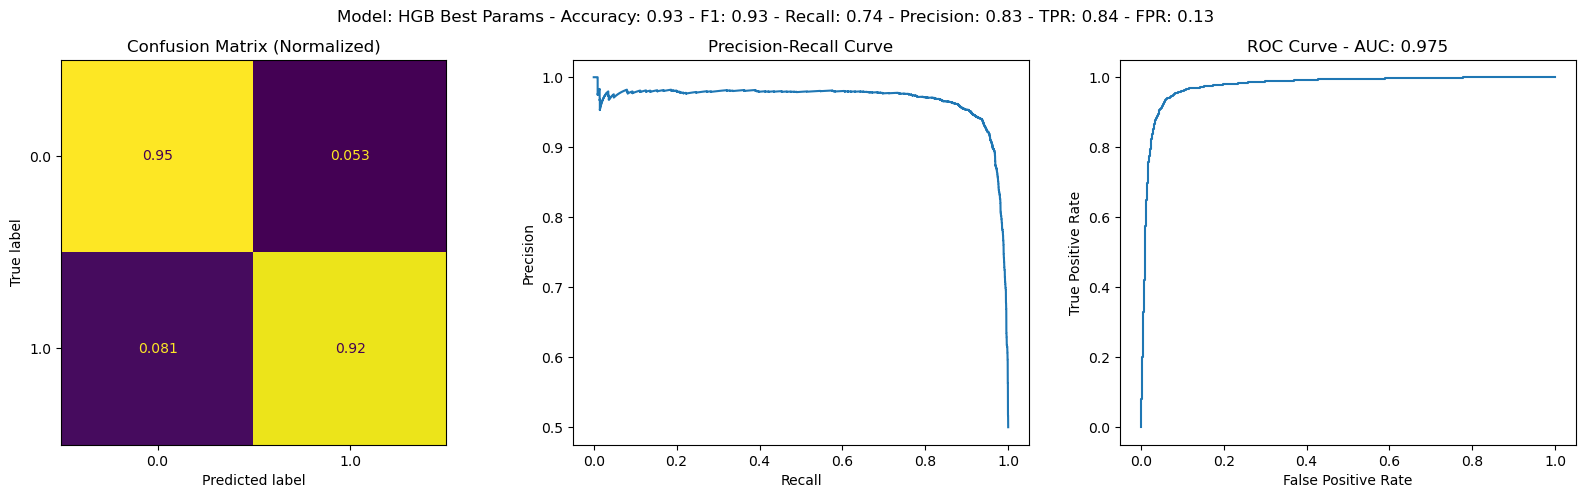

In [137]:
best_params = {'learning_rate': 0.07068619051755831,
 'l2_regularization': 0.00022185517620643103,
 'max_iter': 260,
 'max_leaf_nodes': 80,
 'max_depth': 410,
 'max_bins': 127,
 'min_samples_leaf': 26,
 'early_stopping': True}
model = make_pipeline(RobustScaler(unit_variance=True),HistGradientBoostingClassifier(**best_params))
s, c = get_scores(model, X_train_val, y_train_val, X_test, y_test, display=True, name='HGB Best Params')
s

# Neural Networks


> Perform data augmentation

To improve the model performance, we will perform data augmentation on the training set. We will use the following transformations:

- Rotation
- Zoom
- Horizontal and Vertical Flips
- Width and Height Shifts
- Shear Transformation
- Brightness
- Contrast
- Gaussian Noise
- Gaussian Blur
- Motion Blur
- Median Blur
- Random Crop
- To Gray
- Coarse Dropout
- Invert


In [ ]:
# we will use the Keras ImageDataGenerator to augment the data
#from keras.preprocessing.image import ImageDataGenerator

# create an instance of the ImageDataGenerator
#datagen = ImageDataGenerator()
# fit the generator to the data - this will calculate the mean and std of the data
#datagen.fit(X_train)
## get a batch iterator to efficiently iterate over the training data
#train_iterator = datagen.flow(X_train, y_train, batch_size=32)
## get a batch iterator for the validation data
#val_iterator = datagen.flow(X_val, y_val, batch_size=32)
## fit the model
#mod
